# 神经网络反向传播 (NN back propagation)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report #这个包是评估报告

## 1. Visualizing the data

In [2]:
def load_data(path, transpose = True):
    data = sio.loadmat(path)
    y = data.get("y") # (5000, 1)
    y = y.reshape(-1)
    X = data.get("X")
    
    if transpose:
        # for this dataset, you need a transpose to get the orientation right
        X = np.array([im.reshape(20, 20).T for im in X])
        
        # and I flat the image again to preserve the vector presentation
        X = np.array([im.reshape(-1) for im in X])
    return X, y

In [3]:
X, y = load_data('ex4data1.mat', transpose = True)

In [4]:
np.random.choice(np.arange(X.shape[0]), 100)

array([2372, 3674, 1971, 2668,  897,  197, 1787, 1123, 2350, 4361,  677,
        655, 1848, 2037, 2604, 2725,  440, 2844, 2551, 1610, 1268, 3275,
       1799, 1608, 4885,  694, 1200, 2676, 2248, 3076, 1456, 4907, 4276,
       1874,  842,  784, 2313, 4586, 4085, 1386,   10, 2736, 4437, 1431,
       3010, 4673, 3051, 3985, 2505, 3864, 3976,  680, 3274, 2783,  964,
        920,  791,  759, 2593, 3855, 3466, 4035,  235,  337, 3765, 3222,
       2679, 4555,  755, 4926, 4231, 1772, 1279, 2571, 4189, 3141, 1330,
       3785,  630, 2987, 2456, 2507, 2548, 3871, 1380, 3816,   93, 2392,
       1061, 1468, 4986, 4677, 3640, 2408, 4437, 4385, 2238, 3588,  218,
       2750])

In [5]:
def plot_100_image(X):
    sample_idx = np.random.choice(np.arange(X.shape[0]), 100)
    sample_img = X[sample_idx, :]
    fig, ax = plt.subplots(nrows = 10, ncols = 10, sharex = True, sharey = True, figsize = (10, 10))
    
    for r in range(10):
        for c in range(10):
            ax[r, c].matshow(sample_img[r + c*10].reshape(20, 20), cmap = matplotlib.cm.binary)
            plt.xticks([])
            plt.yticks([])
    plt.show()

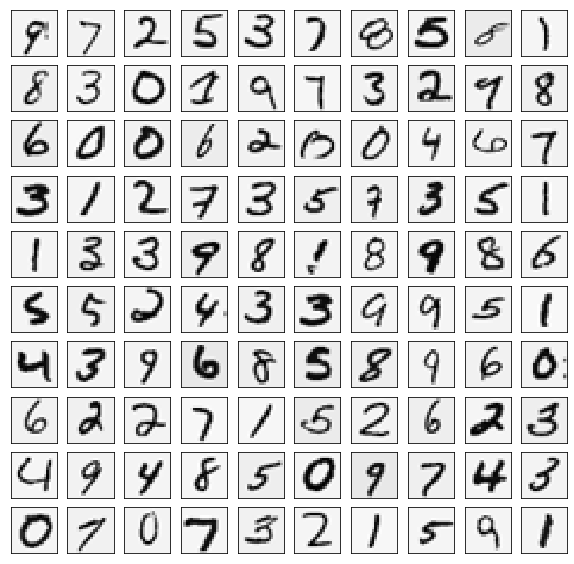

In [6]:
plot_100_image(X)

## 代价函数

In [7]:
X_raw, y_raw = load_data('ex4data1.mat', transpose = False)
X = np.insert(X_raw, 0, np.ones(X_raw.shape[0]), axis = 1) # 增加全部为1的一列
X.shape

(5000, 401)

In [8]:
def expand_y1(y_raw):
    result = []
    for element in y_raw:
        a = np.zeros(10)
        if element == 10:
            a[0] = 1
        else:
            a[element] = 1
        result.append(a)
    return np.array(result)

In [9]:
def expand_y(y_raw):
    res = []
    
    for element in y_raw:
        template = np.zeros(10)
        template[element - 1] = 1
        res.append(template)
    return np.array(res)

In [10]:
y = expand_y(y_raw)
y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

## 读取权重

In [11]:
def load_weight(path):
    weight = sio.loadmat(path)
    return weight["Theta1"], weight["Theta2"]
    # theta1 = weight.get("Theta1")
    # theta2 = weight.get("Theta2")
    # return theta1, theta2

In [12]:
theta1, theta2 = load_weight('ex4weights.mat')
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [13]:
def serialize(a, b):
    return np.concatenate((a.ravel(), b.ravel()))

In [14]:
theta = serialize(theta1, theta2)
theta.shape

(10285,)

## 前向传播 (feed forward)

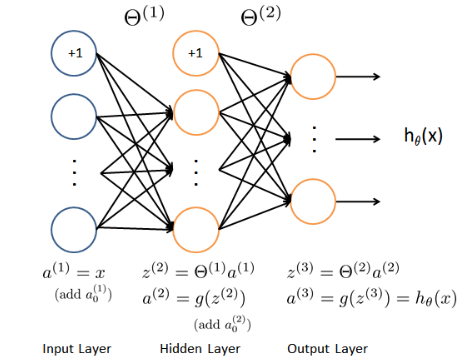

In [15]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [16]:
def deserialize(seq):
    return seq[:25*401].reshape(25, 401), seq[25*401:25*401 + 10*26].reshape(10, 26)

In [17]:
def feed_forward(theta, X):
    theta1, theta2 = deserialize(theta) # theta1: 25x401, theta2: 10x26
    m = X.shape[0]
    a1 = X # 5000*401
    
    z2 = a1@theta1.T # z2: 5000x25
    a2 = np.insert(sigmoid(z2), 0, np.ones(m), axis = 1) # a2: 5000x26
    
    z3 = a2@theta2.T # z3: 5000x10
    h = sigmoid(z3) # a3: 5000x10
    
    return a1, z2, a2, z3, h

In [18]:
_, _, _, _, h = feed_forward(theta, X)
h

array([[1.12661530e-04, 1.74127856e-03, 2.52696959e-03, ...,
        4.01468105e-04, 6.48072305e-03, 9.95734012e-01],
       [4.79026796e-04, 2.41495958e-03, 3.44755685e-03, ...,
        2.39107046e-03, 1.97025086e-03, 9.95696931e-01],
       [8.85702310e-05, 3.24266731e-03, 2.55419797e-02, ...,
        6.22892325e-02, 5.49803551e-03, 9.28008397e-01],
       ...,
       [5.17641791e-02, 3.81715020e-03, 2.96297510e-02, ...,
        2.15667361e-03, 6.49826950e-01, 2.42384687e-05],
       [8.30631310e-04, 6.22003774e-04, 3.14518512e-04, ...,
        1.19366192e-02, 9.71410499e-01, 2.06173648e-04],
       [4.81465717e-05, 4.58821829e-04, 2.15146201e-05, ...,
        5.73434571e-03, 6.96288990e-01, 8.18576980e-02]])

## 代价函数

$$ J(\Theta) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K\left[y_k^{(i)}\log(h_\Theta(x^{(i)}))_k + (1 - y_k^{(i)})\log(1 - (h_\Theta(x^{(i)})_k) \right] $$

think about this, now we have $y$ and $h_{\theta} \in R^{5000 \times 10}$  
If you just ignore the m and k dimention, pairwisely this computation is trivial.  
the eqation $= -y*log(h_{\theta}) - (1-y)*log(1-h_{\theta})$  
all you need to do after pairwise computation is sums this 2d array up and divided by m

In [19]:
def cost(theta, X, y):
    m = X.shape[0]
    _, _, _, _, h = feed_forward(theta, X) # h: 5000x10
    #return np.sum(-y*np.log(h) - (1 - y)*np.log(1 - h))/m

    pair_computation = -np.multiply(y, np.log(h)) - np.multiply((1 - y), np.log(1 - h))

    return pair_computation.sum() / m

In [20]:
cost(theta, X, y)

0.2876291651613189

## 正则化代价函数

原始的代价函数公式：

$$J(\Theta) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K\left[y_k^{(i)}\log(h_\Theta(x^{(i)}))_k + (1 - y_k^{(i)})\log(1 - (h_\Theta(x^{(i)})_k) \right] + \frac{\lambda}{2m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}(\Theta_{ji}^{(l)})^2$$

针对当前网络架构的代价函数公式：

$$ J(\Theta) = -\frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K\left[y_k^{(i)}\log(h_\Theta(x^{(i)}))_k + (1 - y_k^{(i)})\log(1 - (h_\Theta(x^{(i)})_k) \right] + \frac{\lambda}{2m}\left[\sum_{i=1}^{400}\sum_{j=1}^{25}(\Theta_{ji}^{(1)})^2 + \sum_{i=1}^{25}\sum_{j=1}^{10}(\Theta_{ji}^{(2)})^2\right] $$

the first column of t1 and t2 is intercept $\theta$, just forget them when you do regularization.

In [21]:
def regularized_cost(theta, X, y, lam = 1):
    m = X.shape[0]
    theta1, theta2 = deserialize(theta)
    regularized_term = (lam/(2*m))*(np.sum(np.power(theta1,2)[:,1:]) + np.sum(np.power(theta2,2)[:,1:]))
    return cost(theta, X, y) + regularized_term

In [22]:
regularized_cost(theta, X, y)

0.38376985909092365

## 反向传播

读取数据和权重过程与前向传播相同

In [23]:
X.shape, y.shape

((5000, 401), (5000, 10))

In [24]:
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [25]:
theta.shape

(10285,)

In [26]:
def sigmoid_gradient(z):
    return sigmoid(z)*(1 - sigmoid(z))

In [27]:
sigmoid_gradient(0)

0.25

## theta gradient

In [28]:
a1, z2, a2, z3, h = feed_forward(theta, X)
a1.shape, z2.shape, a2.shape, z3.shape, h.shape

((5000, 401), (5000, 25), (5000, 26), (5000, 10), (5000, 10))

In [29]:
def gradient(theta, X, y):
    a1, z2, a2, z3, h = feed_forward(theta, X) # a1: 5000x401; z2: 5000x25; a2: 5000x26; z3: 5000x10; h: 5000x10
    theta1, theta2 = deserialize(theta) # theta1: 25x401; theta2: 10x26
    
    delta3 = h - y # delta3: (5000,10)
    delta2 = delta3@theta2*a2*(1-a2) # delta2: (5000, 26)
    
    # gradient2: (5000, 10, 26)
    gradient2 = np.array([np.outer(delta3[i,:],a2[i,:]) for i in np.arange(len(delta3))])
    # gradient1: (5000, 25, 401)
    gradient1 = np.array([np.outer(delta2[i,1:],a1[i,:]) for i in np.arange(len(delta2))])
    
    mean_gradient2 = np.mean(gradient2, axis = 0) # mean_gradient2: (10, 26)
    mean_gradient1 = np.mean(gradient1, axis = 0) # mean_gradient1: (25, 401)
    
    return serialize(mean_gradient1, mean_gradient2)    

In [30]:
d1, d2 = deserialize(gradient(theta, X, y))

In [31]:
d1.shape, d2.shape

((25, 401), (10, 26))

## 梯度校验

$$ f_i{(\theta)} \approx \frac{J(\theta^{(i+\epsilon)}) - J(\theta^{(i-\epsilon)})}{2\epsilon} $$

In [32]:
def gradient_checking(theta, X, y, epsilon, regularized = False):
    def a_numeric_grad(plus, minus, regularized = False):
        """calculate a partial gradient with respect to 1 theta"""
        if regularized:
            return (regularized_cost(plus, X, y) - regularized_cost(minus, X, y))/(2*epsilon)
        else:
            return (cost(plus, X, y) - cost(minus, X, y))/(2*epsilon)
    def expand_array(arr):
        return np.array([arr for i in np.arange(len(arr))])
    
    expand_theta = expand_array(theta)
    epsilon_mat = np.identity(len(theta))*epsilon
    plus_mat = expand_theta + epsilon_mat
    minus_mat = expand_theta - epsilon_mat
    
    numeric_grad = np.array([a_numeric_grad(plus_mat[i], minus_mat[i], regularized) 
                             for i in np.arange(len(plus_mat))])
    
    analytic_grad = regularized_gradient(theta, X, y) if regularized else gradient(theta, X, y)
    
    # if you have a correct implementation, and assuming you used EPSILON = 0.0001
    # the diff below should be less than 1e-9
    # this is how original matlab code do gradient checking
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad)
    
    print('If your backpropagation implementation is correct,\
          \nthe relative difference will be smaller than 10e-9 (assume epsilon = 0.0001).\
          \nRelative Difference: {}\n'.format(diff))
    

In [33]:
# 先注释掉下边语句，需要运行时再打开
# gradient_checking(theta, X, y, epsilon = 0.0001) # 这个运行很慢，谨慎运行

## regularized gradient

Use normal gradient + regularized term

$$ 
\frac{\partial J(\Theta)}{\partial \Theta_{ij}^{(l)}} = 
\begin{cases}\begin{align}
D_{ij}^{(l)} &:= \frac{1}{m}\Delta_{ij}^{(l)} +  \frac{\lambda}{m}\Theta_{ij}^{(l)}\qquad &\text{if $ j \neq 0$} \\[2ex]
D_{ij}^{(l)} &:= \frac{1}{m}\Delta_{ij}^{(l)} \qquad &\text{if $ j = 0$}
\end{align}\end{cases}$$

In [34]:
def regularized_gradient(theta, X, y, lam = 1):
    m = len(X)
    
    d1, d2 = deserialize(gradient(theta, X, y))
    theta1, theta2 = deserialize(theta)
    
    regularized_theta1 = (lam/m)*theta1
    regularized_theta1[:,0] = 0
    
    regularized_theta2 = (lam/m)*theta2
    regularized_theta2[:,0] = 0
    
    D1 = d1 + regularized_theta1
    D2 = d2 + regularized_theta2
    
    return serialize(D1,D2)

In [35]:
# 先注释掉下边语句，需要运行时再打开
# gradient_checking(theta, X, y, epsilon = 0.0001, regularized = True) # 这个运行很慢，谨慎运行

## ready to train the model

 remember to randomly initlized the parameters to break symmetry

take a look at the doc of this argument: `jac`

>jac : bool or callable, optional
Jacobian (gradient) of objective function. Only for CG, BFGS, Newton-CG, L-BFGS-B, TNC, SLSQP, dogleg, trust-ncg. **If jac is a Boolean and is True, fun is assumed to return the gradient along with the objective function.** If False, the gradient will be estimated numerically. jac can also be a callable returning the gradient of the objective. In this case, it must accept the same arguments as fun.

it means if your `backprop` function return `(cost, grad)`, you could set `jac=True`  

This is the implementation of http://nbviewer.jupyter.org/github/jdwittenauer/ipython-notebooks/blob/master/notebooks/ml/ML-Exercise4.ipynb

but I choose to seperate them

In [36]:
def random_init(size):
    return np.random.uniform(-0.12, 0.12, size)

In [37]:
counter = 1
def nn_training(X, y):
    """regularized version
    the architecture is hard coded here... won't generalize
    """
    init_theta = random_init(25*401 + 10*26)

    def callback_fun(xi):
        global counter
        print("counter : ", counter)
        counter += 1    

    res = opt.minimize(fun = regularized_cost, x0 = init_theta, args = (X, y, 1),
                      method = 'TNC', jac = regularized_gradient, 
                      callback = callback_fun, options = {'maxiter': 400})
    return res

In [38]:
res = nn_training(X, y) # 运行比较慢
print("finished...")
res

counter :  1
counter :  2
counter :  3
counter :  4
counter :  5
counter :  6
counter :  7
counter :  8
counter :  9
counter :  10
counter :  11
counter :  12
counter :  13
counter :  14
counter :  15
counter :  16
counter :  17
counter :  18
counter :  19
counter :  20
counter :  21
counter :  22
counter :  23
counter :  24
counter :  25
counter :  26
finished...


     fun: 0.3174695396072702
     jac: array([-1.21675795e-04, -1.32281268e-09,  1.14047600e-09, ...,
       -1.58920919e-05, -7.78381618e-07,  1.95199379e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 401
     nit: 26
  status: 3
 success: False
       x: array([ 3.25825591e-01, -6.61406341e-06,  5.70237999e-06, ...,
        2.97873985e-01, -9.99252346e-01,  8.72254007e-01])

## 显示准确率

In [39]:
_, y_answer = load_data('ex4data1.mat')
y_answer[:20]

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10], dtype=uint8)

In [40]:
final_theta = res.x

In [41]:
# this function has some problem so it don't be used
def show_accuracy(theta, X, y):
    _, _, _, _, h = feed_forward(theta, X)
    y_pred = np.argmax(h, axis = 1) + 1
    print(classification_report(y, y_pred))

## 显示隐藏层

In [42]:
def plot_hidden_layer(theta):
    final_theta1, _ = deserialize(theta)
    hidden_layer = final_theta1[:,1:] # get rid of bias term theta
    
    fig, ax_array = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (5, 5))
    
    for r in range(5):
        for c in range(5):
            ax_array[r, c].matshow(hidden_layer[r + c*5,:].reshape(20, 20), cmap = matplotlib.cm.binary)
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))
    plt.show()

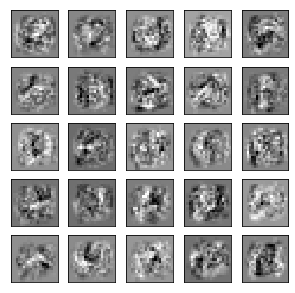

In [43]:
plot_hidden_layer(final_theta)